In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA_PATH =  '../../../data/cluster/year/'
[f for f in os.listdir(DATA_PATH) if 'full' in f]

['X_test_full.csv',
 'X_train_full.csv',
 'X_valid_full.csv',
 'y_test_full.csv',
 'y_train_full.csv',
 'y_valid_full.csv']

In [3]:
X_train = pd.read_csv(DATA_PATH + 'X_train_full.csv')
X_valid = pd.read_csv(DATA_PATH + 'X_valid_full.csv')
X_test  = pd.read_csv(DATA_PATH + 'X_test_full.csv')
y_train = pd.read_csv(DATA_PATH + 'y_train_full.csv')
y_valid = pd.read_csv(DATA_PATH + 'y_valid_full.csv')
y_test  = pd.read_csv(DATA_PATH + 'y_test_full.csv')

X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_valid = X_valid.drop(['Unnamed: 0'], axis=1)
X_test  = X_test.drop(['Unnamed: 0'],  axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_valid = y_valid.drop(['Unnamed: 0'], axis=1)
y_test  = y_test.drop(['Unnamed: 0'],  axis=1)


print('train: X %s\t y%s' % (X_train.shape, y_train.shape))
print('valid: X %s\t y%s' % (X_valid.shape, y_valid.shape))
print('test:  X %s\t y%s' % (X_test.shape,  y_test.shape))

train: X (529623, 25)	 y(529623, 1)
valid: X (117694, 25)	 y(117694, 1)
test:  X (117694, 25)	 y(117694, 1)


In [4]:
util.print_percent_presence(y_train, 'y_train')
util.print_percent_presence(y_valid, 'y_valid')
util.print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 17.23%
Percent presence in y_valid: 13.29%
Percent presence in y_test: 12.54%


In [5]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  train:', 100 - 17.26)
print('  valid:', 100 - 13.92)
print('  test: ', 100 - 12.64)

Baseline accuracy if predicting "absent" for all cells:
  train: 82.74
  valid: 86.08
  test:  87.36


In [6]:
np.isfinite(X_valid).all()

year                        True
meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
studyArea                   True
elev_srtm30                 True
x                           True
y                           True
next_year_beetle            True
dtype: bool

In [7]:
X_train, y_train = util.drop_nans(
    X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'varPrecip_growingSeason')

(527766, 25) (527766, 1)
(116732, 25) (116732, 1)
(117472, 25) (117472, 1)


In [8]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [9]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_test  = X_test.drop(['studyArea',  'x', 'y', 'elev_srtm30', 'year'],  axis=1)

In [10]:
predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']


In [11]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [12]:
y_train = y_train['beetle'].values.reshape(-1)
y_valid = y_valid['beetle'].values.reshape(-1)
y_test  = y_test['beetle'].values.reshape(-1)

# Baseline Logistic Regression 
#### With L1 (_Lasso Regression_) or L2 (_Ridge Regression_ ) Regularization
This model will be considered the baseline for logistic regression models as it uses just the raw predictors.  After some EDA, various transformations and interaction terms will also be considered in order to improve the model.

In [16]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
Cs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

t0 = time.time()
for C in Cs:
    print('Testing C =', C, end='; ')
    for penalty in ['l1', 'l2']:
        print('(%s)' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_test, y_test)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.0001; (l1) Elapsed time: 0.00 minutes
(l2) Elapsed time: 0.01 minutes
Testing C = 0.0005; (l1) Elapsed time: 0.01 minutes
(l2) Elapsed time: 0.02 minutes
Testing C = 0.001; (l1) Elapsed time: 0.03 minutes
(l2) Elapsed time: 0.03 minutes
Testing C = 0.005; (l1) Elapsed time: 0.07 minutes
(l2) Elapsed time: 0.08 minutes
Testing C = 0.01; (l1) Elapsed time: 0.14 minutes
(l2) Elapsed time: 0.15 minutes
Testing C = 0.05; (l1) Elapsed time: 0.34 minutes
(l2) Elapsed time: 0.35 minutes
Testing C = 0.1; (l1) Elapsed time: 0.46 minutes
(l2) Elapsed time: 0.48 minutes
Testing C = 0.5; (l1) Elapsed time: 0.65 minutes
(l2) Elapsed time: 0.67 minutes
Testing C = 1; (l1) Elapsed time: 0.85 minutes
(l2) Elapsed time: 0.87 minutes


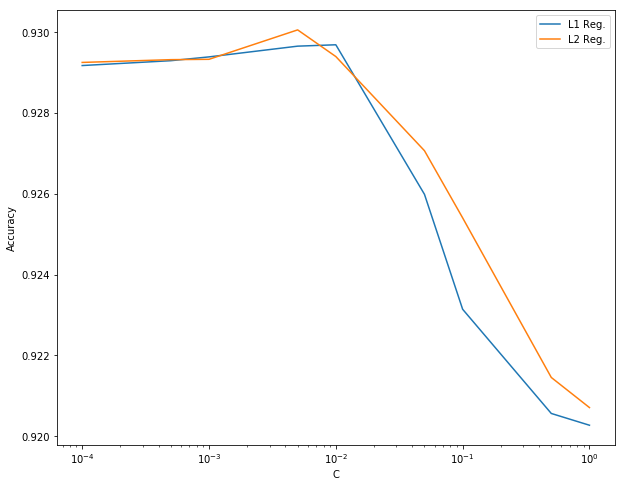

In [17]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [18]:
print(l1_mods)
print(l2_mods)

[0.92917109275948329, 0.9292910255970942, 0.92938525854093135, 0.92965082410992705, 0.92968509063495874, 0.92598430593153547, 0.92314018435390466, 0.92056162834526956, 0.92027036288250008]
[0.92924819244080459, 0.92931672549086797, 0.92932529212212589, 0.93005345577904941, 0.92939382517218927, 0.92706370147003392, 0.92540177500599663, 0.9214525579960936, 0.92070726107665424]


In [19]:
logistic_clf = LogisticRegression(C=0.005, penalty='l2')
logistic_clf.fit(X_train, y_train)
preds = logistic_clf.predict(X_test)
accuracy = sum(y_test == preds) / len(preds)
accuracy

0.93199230454916915

In [20]:
def get_predictions_at_threshold(pred_ps, threshold):
    return 1 * (pred_ps >= threshold)

def threshold_plot(pred_ps, targets):
    thresholds = np.linspace(0, 1, 500)
    accuracies = []
    n = len(pred_ps)

    for threshold in thresholds:
        preds = get_predictions_at_threshold(pred_ps, threshold)
        accuracies.append((preds == targets).sum() / n)
        
    plt.plot(thresholds, accuracies);
    optimal_threshold = thresholds[np.argmax(accuracies)]
    optimal_accuracy = max(accuracies)
    plt.plot([optimal_threshold, optimal_threshold], 
             [min(accuracies), max(accuracies)], 
             'r')
    plt.plot([0, 1], [optimal_accuracy, optimal_accuracy], 'r')
    plt.xlabel('Threshold for predicting "Renewal"')
    plt.ylabel('Accuracy')
    plt.show()
    return {'threshold': optimal_threshold, 'accuracy': optimal_accuracy}

[[ 0.99780558  0.00219442]
 [ 0.99801101  0.00198899]
 [ 0.99869645  0.00130355]
 [ 0.99563067  0.00436933]
 [ 0.99584074  0.00415926]]


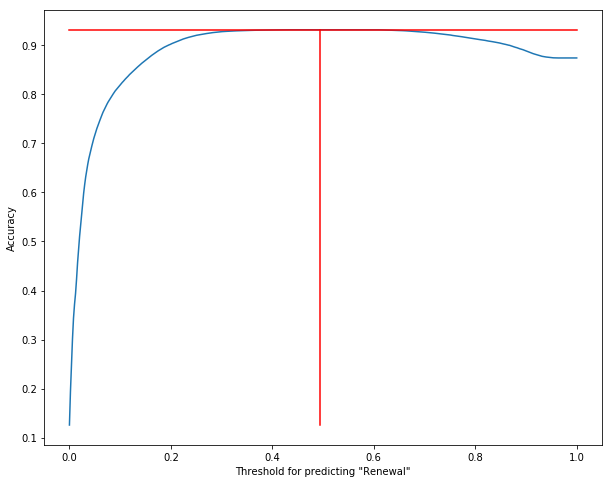

{'threshold': 0.49298597194388771, 'accuracy': 0.9320263552165623}


In [21]:
pred_ps = logistic_clf.predict_proba(X_test)
print(pred_ps[:5])
pred_ps = np.array([p[1] for p in pred_ps])
pred_ps[:5]

THRESHOLD = 0.5
preds = get_predictions_at_threshold(pred_ps, THRESHOLD)
preds[:5]

best_threshold = threshold_plot(pred_ps, y_test);
print(best_threshold)

In [22]:
preds = logistic_clf.predict(X_test)

In [23]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.5)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	10745		4013
        0	3976		98738
Accuracy:  0.931992304549
Precision: 0.729909652877
Recall:    0.728079685594
F1:        0.728993520811


In [24]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.49298597)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	10752		4006
        0	3979		98735
Accuracy:  0.932026355217
Precision: 0.729889348992
Recall:    0.728554004608
F1:        0.729221065482


In [25]:
auc_metrics = util.get_auc(y_test, pred_ps)

AUC:       0.946874652267


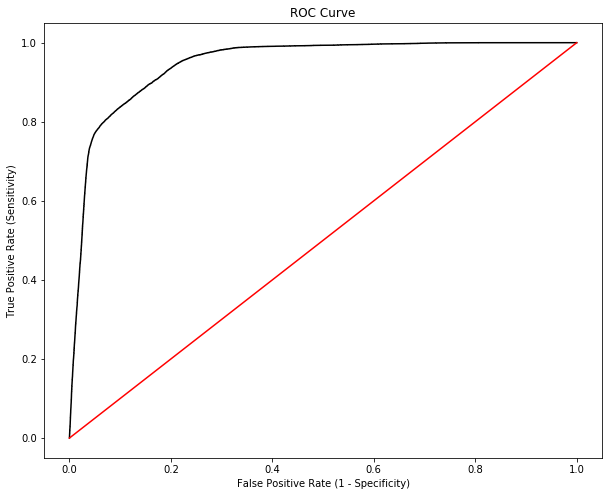

In [26]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])

In [27]:
#predictors
print(len(predictors))
print(len(logistic_clf.coef_[0]))

20
20


In [28]:
coefs = pd.DataFrame([[pred, coef] for pred, coef in zip(predictors, logistic_clf.coef_[0])], 
                     columns=['predictor', 'coef'])
coefs['abs'] = np.abs(coefs.coef)
coefs = coefs.sort_values('abs', ascending=False)
coefs = coefs.drop(['abs'], axis=1)
coefs

,predictor,coef
7,meanMaxTemp_Aug,1.400084
19,next_year_beetle,1.153036
10,vegetation,1.067121
2,meanTemp_Aug,-0.966533
1,meanTemp_AprAug,-0.919322
17,lat,0.860152
5,meanMinTemp_Jan,0.577589
16,elev_etopo1,0.509286
8,precip_meanAnnual,-0.409025
14,precip_growingSeason,0.363317


In [13]:
def column2matrix(dataframe, column, cell_dim=10000):
    '''                                                                          
    Convert a column from DataFrame df into a matrix representation with the     
    upper-left cell indexing beginning at [0, 0].                                
    It is expected that the DataFrame has columns x and y.                       
                                                                                 
    Args:                                                                        
    df: DataFrame: the source data                                               
    column: string: the column name to extract                                   
    cel_dim: numeric: the dimensions of each grid cell                           
                                                                                 
    Returns: np.ndarray (a 2D list; matrix)                                      
    '''
    df = dataframe.copy()
    x_min = df.x.min()
    y_min = df.y.min()
    df.x -= x_min
    df.y -= y_min
    xs = sorted(df.x.unique())
    ys = sorted(df.y.unique())
    matrix = np.array([[np.nan for y in range(len(ys))]
                       for x in range(len(xs))])

    for row in df.index:
        x, y, value = df.loc[row, ['x', 'y', column]]
        i = int((x - xs[0]) / cell_dim)
        j = int((y - ys[0]) / cell_dim)
        matrix[i, j] = value

    return matrix